<a href="https://colab.research.google.com/github/nwesleybhz/nwesley/blob/main/go_hosp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

# Abra a planilha pelo nome
planilha = gc.open("go_hosp")

# Selecione uma aba pelo nome
aba = planilha.worksheet("cobrança")

import pandas as pd
import numpy as np

dados = aba.get_all_values()
cabecalho = dados[0]  # A primeira linha contém o cabeçalho
valores = dados[1:]   # As linhas restantes contêm os valores

df = pd.DataFrame(valores, columns=cabecalho)

# 1. Converter a coluna 'mes_ano' para datetime com o formato correto
df['mes_ano'] = pd.to_datetime(df['mes_ano'], format='%d/%m/%Y %H:%M:%S', errors='coerce')

# 2. Criar a coluna 'mes_ano_str' com o formato 'MM-YYYY' para agrupamento
df['mes_ano_str'] = df['mes_ano'].dt.strftime('%m-%Y')

# 3. Limpar e converter a coluna 'total_serv' para numérico
df['total_serv'] = df['total_serv'].str.strip().str.replace('.', '').str.replace(',', '.')
df['total_serv'] = pd.to_numeric(df['total_serv'], errors='coerce')
df['total_serv'] = df['total_serv'].fillna(0)  # Substitui valores NaN por 0

# 3.1 Limpar e converter a coluna 'total_int' para inteiro
df['total_int'] = df['total_int'].str.strip().str.replace('.', '').str.replace(',', '')
df['total_int'] = pd.to_numeric(df['total_int'], errors='coerce').astype('Int64')  # Convert to integer type
df['total_int'] = df['total_int'].fillna(0)  # Substitui valores NaN por 0

# 4. Converter 'mes_ano_str' para datetime para comparação precisa
df['mes_ano_str'] = pd.to_datetime(df['mes_ano_str'], format='%m-%Y')

# 5. Filtrar o DataFrame no período desejado: de '10-2023' a '09-2024'
inicio_periodo = pd.to_datetime('10-2023', format='%m-%Y')
fim_periodo = pd.to_datetime('09-2024', format='%m-%Y')
df_filtrado = df[(df['mes_ano_str'] >= inicio_periodo) & (df['mes_ano_str'] <= fim_periodo)]

# Certifique-se de que as colunas 'Hospital' e 'cod_hosp' existam no DataFrame
if 'Hospital' not in df.columns or 'cod_hosp' not in df.columns:
    print("As colunas 'Hospital' ou 'cod_hosp' não estão presentes no DataFrame.")
else:
    # 6. Agrupar por 'mes_ano_str', 'Hospital', e 'cod_hosp' e calcular a soma de 'total_int' e 'total_serv'
    df_agrupado = df_filtrado.groupby(['mes_ano_str', 'Hospital', 'cod_hosp'])[['total_int', 'total_serv']].sum().reset_index()

    # Agora todas as colunas estão no mesmo nível
    # 7. Exibir o resultado
    print(df_agrupado)


   mes_ano_str                     Hospital cod_hosp  total_int  total_serv
0   2023-10-01                  Monte Sinai        4          3       786.0
1   2023-10-01       Nossa Senhora da Saúde        1          9      2358.0
2   2023-10-01     Santa Casa de Diamantina        3          0         0.0
3   2023-10-01  Santa Casa de Montes Claros        5          2       524.0
4   2023-10-01         São Vicente de Paulo        2          0         0.0
5   2023-11-01                  Monte Sinai        4          4      1048.0
6   2023-11-01       Nossa Senhora da Saúde        1          7      1834.0
7   2023-11-01     Santa Casa de Diamantina        3          6      1572.0
8   2023-11-01  Santa Casa de Montes Claros        5          5      1310.0
9   2023-11-01         São Vicente de Paulo        2          0         0.0
10  2023-12-01                  Monte Sinai        4          2       524.0
11  2023-12-01       Nossa Senhora da Saúde        1          9      2358.0
12  2023-12-

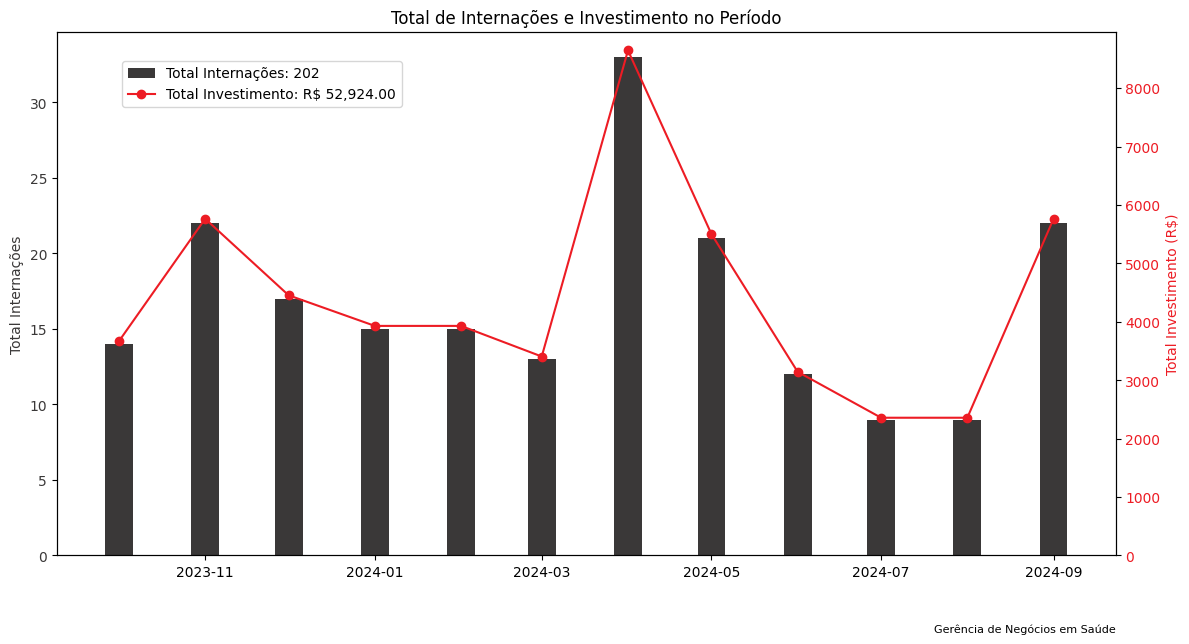

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Certificar que a coluna 'mes_ano_str' está no formato datetime para ordenação
df_agrupado['mes_ano_str'] = pd.to_datetime(df_agrupado['mes_ano_str'], format='%Y-%m-%d')

# Agrupar por 'mes_ano_str' e calcular a soma de 'total_int' e 'total_serv'
df_agrupado2 = df_agrupado.groupby('mes_ano_str').agg({
    'total_int': 'sum',
    'total_serv': 'sum'
}).reset_index()

# Ordenar o DataFrame pela data
df_agrupado2 = df_agrupado2.sort_values('mes_ano_str')

# Calcular os totais de internações e investimentos
total_internacoes = df_agrupado2['total_int'].sum()
total_investimento = df_agrupado2['total_serv'].sum()

# Criar o gráfico
fig, ax1 = plt.subplots(figsize=(12, 6))

# Gráfico de barras para 'total_int' (internações) com barras mais largas (width=0.9)
bars = ax1.bar(df_agrupado2['mes_ano_str'], df_agrupado2['total_int'], color='#3A3838', label=f'Total Internações: {total_internacoes}', width=10)
ax1.set_xlabel('')
ax1.set_ylabel('Total Internações', color='#3A3838')
ax1.tick_params('y', labelcolor='#3A3838')

# Criar o segundo eixo Y para a linha de 'total_serv' (investimento)
ax2 = ax1.twinx()
ax2.plot(df_agrupado2['mes_ano_str'], df_agrupado2['total_serv'], color='#ED1C24', marker='o', linestyle='-', label=f'Total Investimento: R$ {total_investimento:,.2f}')
ax2.set_ylabel('Total Investimento (R$)', color='#ED1C24')
ax2.tick_params('y', labelcolor='#ED1C24')

# Adicionar título ao gráfico
plt.title('Total de Internações e Investimento no Período')

# Ajustar os limites dos eixos Y
ax1.set_ylim(ymin=0)
ax2.set_ylim(ymin=0)

# Configurar a legenda
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

# Exibir o gráfico
plt.tight_layout()

# Adiciona a notação "Gerência de Negócios em Saúde" no canto inferior direito
plt.text(1, -0.15, "Gerência de Negócios em Saúde", transform=plt.gca().transAxes,
         fontsize=8, horizontalalignment='right', verticalalignment='bottom')

plt.show()


In [ ]:
#auditoria concorrente
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

# Abra a planilha pelo nome
planilha = gc.open("go_hosp")

# Selecione uma aba pelo nome
aba = planilha.worksheet("aud_concorrente")

import pandas as pd
import numpy as np

dados2 = aba.get_all_values()
cabecalho2 = dados[0]  # A primeira linha contém o cabeçalho
valores2 = dados[1:]   # As linhas restantes contêm os valores

dados2 = aba.get_all_values()
cabecalho2 = dados2[0]  # A primeira linha contém o cabeçalho
valores2 = dados2[1:]   # As linhas restantes contêm os valores

df3 = pd.DataFrame(valores2, columns=cabecalho2)  # Create df2

df3.head()






,Hospital,cod_hosp,Paciente,Dt. Admissão,Dt. Alta,Credencial,mês_ano
0,Monte Sinai,4,Marcelo Caiafa Clemente,02/02/2022 00:00:00,18/07/2022 10:00:00,132000482330,01/07/2022 00:00:00
1,Monte Sinai,4,Silvana Alves Conde Campos,13/07/2022 00:00:00,21/07/2022 20:33:00,132005545028,01/07/2022 00:00:00
2,Monte Sinai,4,Matheus Alves Campos,23/07/2022 00:00:00,,132000554501,01/07/2022 00:00:00
3,Monte Sinai,4,Maria do Carmo Estevam da Silveira,23/07/2022 00:00:00,27/07/2022 18:13:00,102003921250,01/07/2022 00:00:00
4,Monte Sinai,4,Anelise Franco Orilio,23/07/2022 00:00:00,25/07/2022 16:40:00,132022812410,01/07/2022 00:00:00


In [ ]:
#exibir formato das colunas
df3.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Hospital      431 non-null    object
 1   cod_hosp      431 non-null    object
 2   Paciente      431 non-null    object
 3   Dt. Admissão  431 non-null    object
 4   Dt. Alta      431 non-null    object
 5   Credencial    431 non-null    object
 6   mês_ano       431 non-null    object
dtypes: object(7)
memory usage: 23.7+ KB


In [ ]:
#transformar a coluna Credencial em inteiro
df3['Credencial'].unique()
df3['Credencial'] = df3['Credencial'].astype(int)
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Hospital      431 non-null    object
 1   cod_hosp      431 non-null    object
 2   Paciente      431 non-null    object
 3   Dt. Admissão  431 non-null    object
 4   Dt. Alta      431 non-null    object
 5   Credencial    431 non-null    int64 
 6   mês_ano       431 non-null    object
dtypes: int64(1), object(6)
memory usage: 23.7+ KB


In [ ]:
# 1. Converter a coluna 'mes_ano' para datetime com o formato correto
df3['mês_ano'] = pd.to_datetime(df3['mês_ano'], format='%d/%m/%Y %H:%M:%S', errors='coerce')

# 2. Criar a coluna 'mes_ano_str3' com o formato 'MM-YYYY' para agrupamento
df3['mes_ano_str3'] = df3['mês_ano'].dt.strftime('%m-%Y')

# 4. Converter 'mes_ano_str3' para datetime para comparação precisa
# Alterado de df3['mes_ano_str'] para df3['mes_ano_str3']
df3['mes_ano_str3'] = pd.to_datetime(df3['mes_ano_str3'], format='%m-%Y')

# 5. Filtrar o DataFrame no período desejado: de '08-2023' a '09-2024'
inicio_periodo = pd.to_datetime('09-2023', format='%m-%Y')
fim_periodo = pd.to_datetime('09-2024', format='%m-%Y')
# Alterado de df['mes_ano_str'] para df3['mes_ano_str3'] para manter a consistência
df_filtrado = df3[(df3['mes_ano_str3'] >= inicio_periodo) & (df3['mes_ano_str3'] <= fim_periodo)]

#6. Remover duplicatas de 'Credencial' dentro de cada 'mes_ano_str3'
#df_filtrado = df_filtrado.drop_duplicates(subset=['mes_ano_str3', 'Credencial'], keep='first')

# 6. Agrupar por 'mes_ano_str3' e obter os valores únicos de 'Credencial'
# Alterado para usar agg(list) para obter uma lista de valores únicos
df_agrupado2 = df_filtrado.groupby('mes_ano_str3')['Credencial'].count()

# 8. Renomear a coluna de contagem
df_agrupado2 = df_agrupado2.rename('Total_Credenciais_Distintas')  # Novo nome da coluna

# Converter o índice de volta para string 'MM-YYYY' para exibição
# Alterado de df_agrupado para df_agrupado2
df_agrupado2.index = df_agrupado2.index.strftime('%m-%Y')

# 7. Exibir o resultado
df_agrupado2

,Total_Credenciais_Distintas
mes_ano_str3,
09-2023,16
10-2023,23
11-2023,18
12-2023,18
01-2024,13
02-2024,22
03-2024,14
04-2024,25
05-2024,22


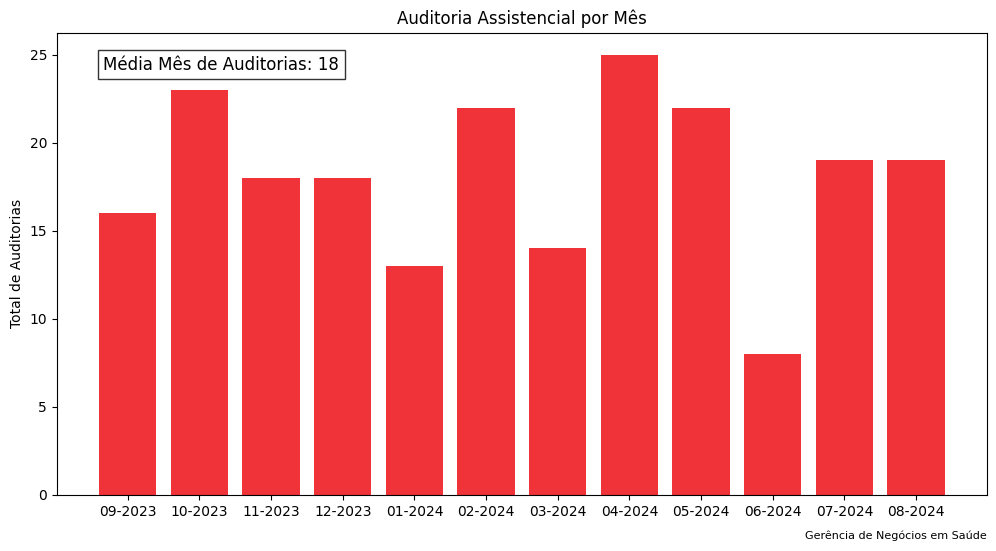

In [ ]:
import matplotlib.pyplot as plt

# Calcula a média de auditorias
media_auditorias = df_agrupado2.mean()

# Cria a legenda com a média formatada
legenda = f'Média Mês de Auditorias: {media_auditorias:.0f}'

# Cria o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(df_agrupado2.index, df_agrupado2.values, color='#EF3339')
plt.xlabel('')
plt.ylabel('Total de Auditorias')
plt.title('Auditoria Assistencial por Mês')

# Adiciona a legenda ao gráfico
plt.text(0.05, 0.95, legenda, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

# Adiciona a notação "Gerência de Negócios em Saúde" no canto inferior direito
plt.text(1, -0.10, "Gerência de Negócios em Saúde", transform=plt.gca().transAxes,
         fontsize=8, horizontalalignment='right', verticalalignment='bottom')

plt.show()

In [152]:
#auditoria de contas
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

# Abra a planilha pelo nome
planilha = gc.open("go_hosp")

# Selecione uma aba pelo nome
aba = planilha.worksheet("aud_contas")

import pandas as pd
import numpy as np

dados = aba.get_all_values()
cabecalho = dados[0]  # A primeira linha contém o cabeçalho
valores = dados[1:]   # As linhas restantes contêm os valores

dados = aba.get_all_values()
cabecalho = dados[0]  # A primeira linha contém o cabeçalho
valores = dados[1:]   # As linhas restantes contêm os valores

df4 = pd.DataFrame(valores, columns=cabecalho)  # Create df2

df4.head()



,Cod. Fatura,Id. Capta,Nome do Paciente,Credencial,Hospital,cod_hosp,Total Bruto,Total Glosado,Internação,Tipo,mês_ano
0,1,6,Jose Angelo Tonon,132000482240,Monte Sinai,4,"3127,45","0,00",Clínica,,01/08/2022 00:00:00
1,2,1,Marcelo Caiafa Clemente,132000482330,Monte Sinai,4,"41327,46","2066,63",Clínica,,01/08/2022 00:00:00
2,3,10,Davi Bernardino de Oliveira Campolina Lamas,132023749531,Monte Sinai,4,"1123,95","1,20",Cirúrgica,,01/08/2022 00:00:00
3,4,1,Marcelo Caiafa Clemente,132000482330,Monte Sinai,4,"78599,57","6350,92",Clínica,,01/08/2022 00:00:00
4,5,11,Maria Aparecida Caldoncelli Franco,132049615790,Monte Sinai,4,"4435,05","175,60",Cirúrgica,,01/08/2022 00:00:00


In [119]:
#exibir formato das colunas
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Cod. Fatura       396 non-null    object
 1   Id. Capta         396 non-null    object
 2   Nome do Paciente  396 non-null    object
 3   Credencial        396 non-null    object
 4   Hospital          396 non-null    object
 5   cod_hosp          396 non-null    object
 6   Total Bruto       396 non-null    object
 7   Total Glosado     396 non-null    object
 8   Internação        396 non-null    object
 9   Tipo              396 non-null    object
 10  mês_ano           396 non-null    object
dtypes: object(11)
memory usage: 34.2+ KB


In [120]:
#tratamento dos dados da coluna Total Bruto
#df4['Total Bruto'].unique()
#df4.info()

df4['Total Bruto'] = df4['Total Bruto'].str.strip().str.replace('.', '').str.replace(',', '.')
df4['Total Bruto'] = pd.to_numeric(df4['Total Bruto'], errors='coerce')
df4['Total Bruto'] = df4['Total Bruto'].fillna(0)  # Substitui valores NaN por 0
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Cod. Fatura       396 non-null    object 
 1   Id. Capta         396 non-null    object 
 2   Nome do Paciente  396 non-null    object 
 3   Credencial        396 non-null    object 
 4   Hospital          396 non-null    object 
 5   cod_hosp          396 non-null    object 
 6   Total Bruto       396 non-null    float64
 7   Total Glosado     396 non-null    object 
 8   Internação        396 non-null    object 
 9   Tipo              396 non-null    object 
 10  mês_ano           396 non-null    object 
dtypes: float64(1), object(10)
memory usage: 34.2+ KB


In [121]:
#tratamento dos dados da coluna Total Glosado
#df4['Total Glosado'].unique()
#df4.info()

df4['Total Glosado'] = df4['Total Glosado'].str.strip().str.replace('.', '').str.replace(',', '.')
df4['Total Glosado'] = pd.to_numeric(df4['Total Glosado'], errors='coerce')
df4['Total Glosado'] = df4['Total Glosado'].fillna(0)  # Substitui valores NaN por 0
df4.info()







<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Cod. Fatura       396 non-null    object 
 1   Id. Capta         396 non-null    object 
 2   Nome do Paciente  396 non-null    object 
 3   Credencial        396 non-null    object 
 4   Hospital          396 non-null    object 
 5   cod_hosp          396 non-null    object 
 6   Total Bruto       396 non-null    float64
 7   Total Glosado     396 non-null    float64
 8   Internação        396 non-null    object 
 9   Tipo              396 non-null    object 
 10  mês_ano           396 non-null    object 
dtypes: float64(2), object(9)
memory usage: 34.2+ KB


In [122]:
# criar a coluna valor_liquido Total Bruto - Total Glosado
df4['valor_liquido'] = df4['Total Bruto'] - df4['Total Glosado']
df4.info()
df4.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Cod. Fatura       396 non-null    object 
 1   Id. Capta         396 non-null    object 
 2   Nome do Paciente  396 non-null    object 
 3   Credencial        396 non-null    object 
 4   Hospital          396 non-null    object 
 5   cod_hosp          396 non-null    object 
 6   Total Bruto       396 non-null    float64
 7   Total Glosado     396 non-null    float64
 8   Internação        396 non-null    object 
 9   Tipo              396 non-null    object 
 10  mês_ano           396 non-null    object 
 11  valor_liquido     396 non-null    float64
dtypes: float64(3), object(9)
memory usage: 37.2+ KB


,Cod. Fatura,Id. Capta,Nome do Paciente,Credencial,Hospital,cod_hosp,Total Bruto,Total Glosado,Internação,Tipo,mês_ano,valor_liquido
0,1,6,Jose Angelo Tonon,132000482240,Monte Sinai,4,3127.45,0.00,Clínica,,01/08/2022 00:00:00,3127.45
1,2,1,Marcelo Caiafa Clemente,132000482330,Monte Sinai,4,41327.46,2066.63,Clínica,,01/08/2022 00:00:00,39260.83
2,3,10,Davi Bernardino de Oliveira Campolina Lamas,132023749531,Monte Sinai,4,1123.95,1.20,Cirúrgica,,01/08/2022 00:00:00,1122.75
3,4,1,Marcelo Caiafa Clemente,132000482330,Monte Sinai,4,78599.57,6350.92,Clínica,,01/08/2022 00:00:00,72248.65
4,5,11,Maria Aparecida Caldoncelli Franco,132049615790,Monte Sinai,4,4435.05,175.60,Cirúrgica,,01/08/2022 00:00:00,4259.45


In [123]:
df4['mês_ano'].unique()
#df4.info()

array(['01/08/2022 00:00:00', '01/09/2022 00:00:00',
       '01/10/2022 00:00:00', '01/11/2022 00:00:00',
       '01/12/2022 00:00:00', '01/01/2023 00:00:00',
       '01/02/2023 00:00:00', '01/06/2023 00:00:00',
       '01/07/2023 00:00:00', '01/03/2023 00:00:00',
       '01/04/2023 00:00:00', '01/05/2023 00:00:00',
       '01/08/2023 00:00:00', '01/09/2023 00:00:00',
       '01/10/2023 00:00:00', '01/11/2023 00:00:00',
       '01/12/2023 00:00:00', '01/01/2024 00:00:00',
       '01/02/2024 00:00:00', '01/03/2024 00:00:00',
       '01/04/2024 00:00:00', '01/05/2024 00:00:00',
       '01/06/2024 00:00:00', '01/07/2024 00:00:00',
       '01/08/2024 00:00:00', '01/09/2024 00:00:00'], dtype=object)

In [124]:
import pandas as pd
import re

# Padrão de expressão regular para extrair mês e ano
pattern = r"(\d{1,2})[/.-](\d{4})"

def extract_date(date_str):
    match = re.search(pattern, str(date_str))
    if match:
        month = match.group(1)
        year = match.group(2)
        return pd.to_datetime(f"{month}-{year}", format='%m-%Y')
    return pd.NaT

df4['mês_ano'] = df4['mês_ano'].apply(extract_date)
df4['mês_ano'] = df4['mês_ano'].dt.strftime('%m-%Y')


# Verify the data type of the column
print(df4['mês_ano'].dtype)  # Output: object (string)

# Check the formatted dates
print(df4['mês_ano'].head())
df4



object
0    08-2022
1    08-2022
2    08-2022
3    08-2022
4    08-2022
Name: mês_ano, dtype: object


,Cod. Fatura,Id. Capta,Nome do Paciente,Credencial,Hospital,cod_hosp,Total Bruto,Total Glosado,Internação,Tipo,mês_ano,valor_liquido
0,1,6,Jose Angelo Tonon,132000482240,Monte Sinai,4,3127.45,0.00,Clínica,,08-2022,3127.45
1,2,1,Marcelo Caiafa Clemente,132000482330,Monte Sinai,4,41327.46,2066.63,Clínica,,08-2022,39260.83
2,3,10,Davi Bernardino de Oliveira Campolina Lamas,132023749531,Monte Sinai,4,1123.95,1.20,Cirúrgica,,08-2022,1122.75
3,4,1,Marcelo Caiafa Clemente,132000482330,Monte Sinai,4,78599.57,6350.92,Clínica,,08-2022,72248.65
4,5,11,Maria Aparecida Caldoncelli Franco,132049615790,Monte Sinai,4,4435.05,175.60,Cirúrgica,,08-2022,4259.45
...,...,...,...,...,...,...,...,...,...,...,...,...
391,389,480,Caetano Moreno Ribeiro Borges,10702165754137,Santa Casa de Montes Claros,5,532.87,0.00,Clínica,Urgência,09-2024,532.87
392,390,485,Luisa Gouvea Vieira Andrade,12100000081118,Santa Casa de Montes Claros,5,1916.32,0.00,Cirúrgica,Eletiva,09-2024,1916.32
393,407,501,Yanca Curty Ribeiro Christoff Ornelas,14301866864028,Santa Casa de Montes Claros,5,5589.65,279.14,Cirúrgica,Urgência,09-2024,5310.51
394,423,499,Emilene Mistica Costa Bruce,10701954985014,Santa Casa de Montes Claros,5,2370.49,22.49,Cirúrgica,Eletiva,09-2024,2348.00


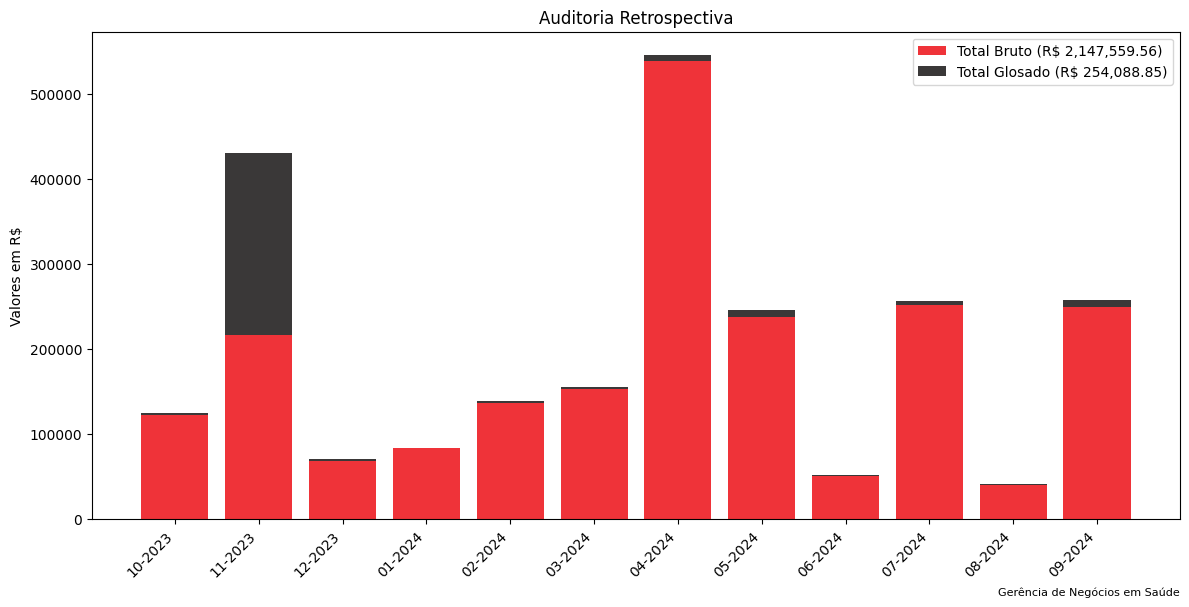

In [125]:
import pandas as pd
import matplotlib.pyplot as plt

# Certifique-se de que a coluna 'mês_ano' esteja no formato datetime
df4['mês_ano'] = pd.to_datetime(df4['mês_ano'], format='%m-%Y')

# Definir o período de filtragem: de 10-2023 a 09-2024
inicio_periodo = pd.to_datetime('10-2023', format='%m-%Y')
fim_periodo = pd.to_datetime('09-2024', format='%m-%Y')

# Filtrar o DataFrame dentro do período desejado
df_filtrado = df4[(df4['mês_ano'] >= inicio_periodo) & (df4['mês_ano'] <= fim_periodo)]

# Ordenar o DataFrame pelo campo 'mês_ano' em ordem crescente
df_filtrado = df_filtrado.sort_values(by='mês_ano')

# Agrupar por 'mês_ano' e somar os valores de 'Total Bruto' e 'Total Glosado'
df_agrupado = df_filtrado.groupby('mês_ano')[['Total Bruto', 'Total Glosado']].sum().reset_index()

# Calcular os totais
total_bruto = df_agrupado['Total Bruto'].sum()
total_glosado = df_agrupado['Total Glosado'].sum()

# Plotar o gráfico de barras empilhadas
plt.figure(figsize=(12, 6))

# Plotar a primeira barra (Total Bruto)
plt.bar(df_agrupado['mês_ano'].dt.strftime('%m-%Y'), df_agrupado['Total Bruto'], label=f'Total Bruto (R$ {total_bruto:,.2f})', color='#EF3339')

# Empilhar a segunda barra (Total Glosado) sobre a primeira
plt.bar(df_agrupado['mês_ano'].dt.strftime('%m-%Y'), df_agrupado['Total Glosado'], label=f'Total Glosado (R$ {total_glosado:,.2f})', bottom=df_agrupado['Total Bruto'], color='#3A3838')

# Ajustar rótulos e título
plt.xlabel('')
plt.ylabel('Valores em R$')
plt.title('Auditoria Retrospectiva')
plt.xticks(rotation=45, ha='right')
plt.legend(title='')

# Exibir o gráfico
plt.tight_layout()

# Adiciona a notação "Gerência de Negócios em Saúde" no canto inferior direito
plt.text(1, -0.16, "Gerência de Negócios em Saúde", transform=plt.gca().transAxes,
         fontsize=8, horizontalalignment='right', verticalalignment='bottom')
plt.show()


In [126]:
df4

,Cod. Fatura,Id. Capta,Nome do Paciente,Credencial,Hospital,cod_hosp,Total Bruto,Total Glosado,Internação,Tipo,mês_ano,valor_liquido
0,1,6,Jose Angelo Tonon,132000482240,Monte Sinai,4,3127.45,0.00,Clínica,,2022-08-01,3127.45
1,2,1,Marcelo Caiafa Clemente,132000482330,Monte Sinai,4,41327.46,2066.63,Clínica,,2022-08-01,39260.83
2,3,10,Davi Bernardino de Oliveira Campolina Lamas,132023749531,Monte Sinai,4,1123.95,1.20,Cirúrgica,,2022-08-01,1122.75
3,4,1,Marcelo Caiafa Clemente,132000482330,Monte Sinai,4,78599.57,6350.92,Clínica,,2022-08-01,72248.65
4,5,11,Maria Aparecida Caldoncelli Franco,132049615790,Monte Sinai,4,4435.05,175.60,Cirúrgica,,2022-08-01,4259.45
...,...,...,...,...,...,...,...,...,...,...,...,...
391,389,480,Caetano Moreno Ribeiro Borges,10702165754137,Santa Casa de Montes Claros,5,532.87,0.00,Clínica,Urgência,2024-09-01,532.87
392,390,485,Luisa Gouvea Vieira Andrade,12100000081118,Santa Casa de Montes Claros,5,1916.32,0.00,Cirúrgica,Eletiva,2024-09-01,1916.32
393,407,501,Yanca Curty Ribeiro Christoff Ornelas,14301866864028,Santa Casa de Montes Claros,5,5589.65,279.14,Cirúrgica,Urgência,2024-09-01,5310.51
394,423,499,Emilene Mistica Costa Bruce,10701954985014,Santa Casa de Montes Claros,5,2370.49,22.49,Cirúrgica,Eletiva,2024-09-01,2348.00


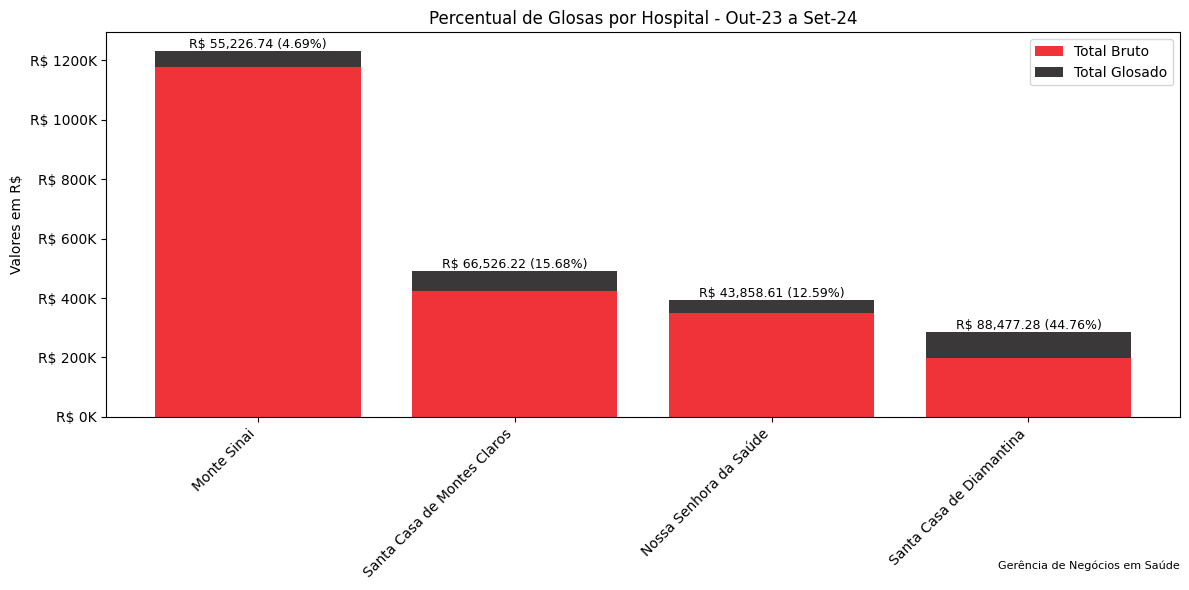

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Certifique-se de que a coluna 'mês_ano' esteja no formato datetime
df4['mês_ano'] = pd.to_datetime(df4['mês_ano'], format='%m-%Y')

# Definir o período de filtragem: de 10-2023 a 09-2024
inicio_periodo = pd.to_datetime('10-2023', format='%m-%Y')
fim_periodo = pd.to_datetime('09-2024', format='%m-%Y')

# Filtrar o DataFrame dentro do período desejado
df_filtrado = df4[(df4['mês_ano'] >= inicio_periodo) & (df4['mês_ano'] <= fim_periodo)]

# Agrupar por 'Hospital' e somar os valores de 'Total Bruto' e 'Total Glosado'
df_agrupado = df_filtrado.groupby('Hospital')[['Total Bruto', 'Total Glosado']].sum().reset_index()

# Calcular o percentual de glosas (soma de Total Glosado / soma de Total Bruto por hospital)
df_agrupado['Percentual Glosas'] = (df_agrupado['Total Glosado'] / df_agrupado['Total Bruto']) * 100

# Ordenar o DataFrame pelo valor total (Total Bruto + Total Glosado) em ordem decrescente
df_agrupado['Total Geral'] = df_agrupado['Total Bruto'] + df_agrupado['Total Glosado']
df_agrupado = df_agrupado.sort_values(by='Total Geral', ascending=False)

# Plotar o gráfico de barras empilhadas
plt.figure(figsize=(12, 6))

# Plotar a primeira barra (Total Bruto)
plt.bar(df_agrupado['Hospital'], df_agrupado['Total Bruto'], label='Total Bruto', color='#EF3339')

# Empilhar a segunda barra (Total Glosado) sobre a primeira
bars = plt.bar(df_agrupado['Hospital'], df_agrupado['Total Glosado'], label='Total Glosado', bottom=df_agrupado['Total Bruto'], color='#3A3838')

# Adicionar rótulos no topo das barras de Total Glosado com o percentual de glosas
for bar, glosado, percentual in zip(bars, df_agrupado['Total Glosado'], df_agrupado['Percentual Glosas']):
    y_val = bar.get_height() + bar.get_y()  # Posição no topo da barra empilhada
    plt.text(bar.get_x() + bar.get_width() / 2, y_val, f'R$ {glosado:,.2f} ({percentual:.2f}%)',
             ha='center', va='bottom', fontsize=9)

# Ajustar rótulos e título
plt.xlabel('')
plt.ylabel('Valores em R$')
plt.title('Percentual de Glosas por Hospital - Out-23 a Set-24')
plt.xticks(rotation=45, ha='right')
plt.legend(title='')

# Formatar o eixo Y para exibir em milhares de reais
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'R$ {x/1000:.0f}K'))

# Exibir o gráfico
plt.tight_layout()

# Adiciona a notação "Gerência de Negócios em Saúde" no canto inferior direito
plt.text(1, -0.40, "Gerência de Negócios em Saúde", transform=plt.gca().transAxes,
         fontsize=8, horizontalalignment='right', verticalalignment='bottom')

plt.show()


In [ ]:
#tempo médio de permanência
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

# Abra a planilha pelo nome
planilha = gc.open("go_hosp")

# Selecione uma aba pelo nome
aba = planilha.worksheet("tmp")

import pandas as pd
import numpy as np

dados = aba.get_all_values()
cabecalho = dados[0]  # A primeira linha contém o cabeçalho
valores = dados[1:]   # As linhas restantes contêm os valores

dados = aba.get_all_values()
cabecalho = dados[0]  # A primeira linha contém o cabeçalho
valores = dados[1:]   # As linhas restantes contêm os valores

df5 = pd.DataFrame(valores, columns=cabecalho)  # Create df2

df5.head()

,Mês,Hospital,cod_hosp,Epecialidade,TMP
0,01/01/2023 00:00:00,Monte Sinai,4,Clinico,"7,00"
1,01/01/2023 00:00:00,Monte Sinai,4,Geral,"7,00"
2,01/01/2023 00:00:00,Nossa Senhora da Saúde,1,Cirúrgico,"3,50"
3,01/01/2023 00:00:00,Nossa Senhora da Saúde,1,G.O,"8,00"
4,01/01/2023 00:00:00,Nossa Senhora da Saúde,1,Geral,"5,50"


In [ ]:
#substituir a vírgula do campo TMP e transformar em inteiro
df5['TMP'] = df5['TMP'].str.replace(',', '.').astype(float)
df5.info()

AttributeError: Can only use .str accessor with string values!

In [ ]:
#transformar o campo Mês em datetime e o formato deve ser 'MM-AAAA'
df5['Mês'] = pd.to_datetime(df5['Mês'], format='%d/%m/%Y %H:%M:%S')
# Changed format to match the actual date format in the column
df5['Mês'] = df5['Mês'].dt.strftime('%m-%Y') # Format the datetime object to 'MM-YYYY'
df5['Mês'] = pd.to_datetime(df5['Mês'], format='%m-%Y') #Convert back to datetime
df5.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Mês           279 non-null    datetime64[ns]
 1   Hospital      279 non-null    object        
 2   cod_hosp      279 non-null    object        
 3   Epecialidade  279 non-null    object        
 4   TMP           279 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 11.0+ KB


In [ ]:
df5['Mês'].unique()

<DatetimeArray>
['2023-01-01 00:00:00', '2023-02-01 00:00:00', '2023-03-01 00:00:00',
 '2023-04-01 00:00:00', '2023-05-01 00:00:00', '2023-06-01 00:00:00',
 '2023-07-01 00:00:00', '2023-08-01 00:00:00', '2023-09-01 00:00:00',
 '2023-10-01 00:00:00', '2023-11-01 00:00:00', '2023-12-01 00:00:00',
 '2024-01-01 00:00:00', '2024-02-01 00:00:00', '2024-03-01 00:00:00',
 '2024-04-01 00:00:00', '2024-05-01 00:00:00', '2024-06-01 00:00:00',
 '2024-07-01 00:00:00', '2024-08-01 00:00:00', '2024-09-01 00:00:00']
Length: 21, dtype: datetime64[ns]

In [ ]:
import pandas as pd

# Certifique-se de que a coluna 'Mês' esteja no formato datetime
df5['Mês'] = pd.to_datetime(df5['Mês'], format='%m-%Y')

# Definir o período de filtragem: de 10-2023 a 09-2024
inicio_periodo = pd.to_datetime('10-2023', format='%m-%Y')
fim_periodo = pd.to_datetime('09-2024', format='%m-%Y')

# Filtrar o DataFrame dentro do período desejado e pela especialidade 'Geral'
df_filtrado = df5[
    (df5['Mês'] >= inicio_periodo) &
    (df5['Mês'] <= fim_periodo) &
    (df5['Epecialidade'] == 'Geral')  # Filtrar por especialidade 'Geral'
]

# Exibir o TMP mês a mês
tmp_por_mes = df_filtrado.groupby('Mês')['TMP'].mean()  # Calcula a média do TMP por mês

print(tmp_por_mes)

Mês
2023-10-01    5.220000
2023-11-01    2.200000
2023-12-01    4.675000
2024-02-01    4.915000
2024-03-01    5.000000
2024-04-01    3.964000
2024-05-01    3.256000
2024-06-01    4.056667
2024-07-01    2.466000
2024-08-01    3.220000
2024-09-01    3.440000
Name: TMP, dtype: float64


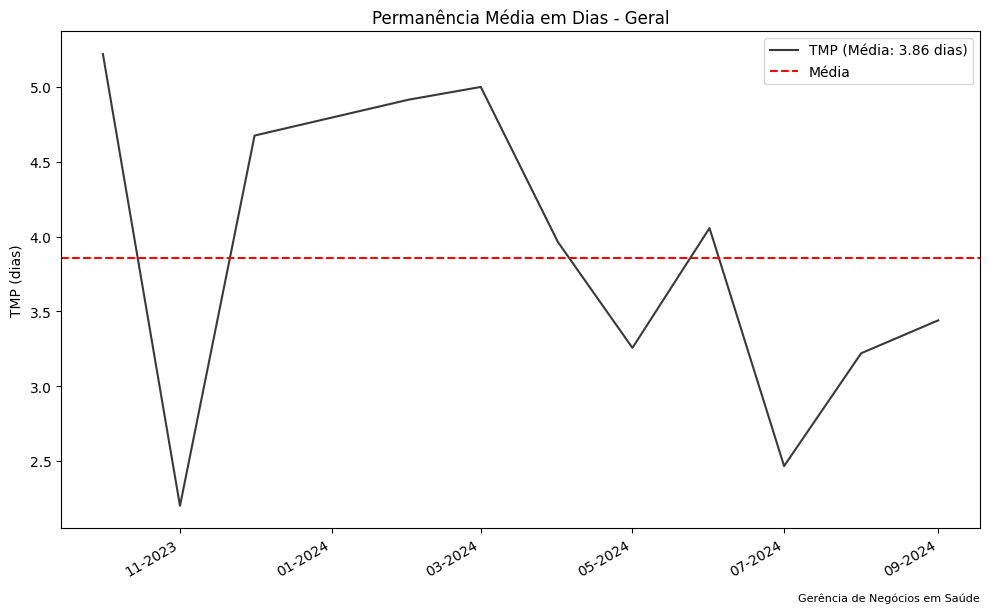

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming df5 is already loaded and 'Mês' is in datetime format

# Filter for 'Geral' specialty (if needed)
df_geral = df5[df5['Epecialidade'] == 'Geral']

# Group by month and calculate average TMP
tmp_por_mes = df_geral.groupby('Mês')['TMP'].mean()

# Sort by month (index)
tmp_por_mes = tmp_por_mes.sort_index()

# Filter for the desired period
inicio_periodo = pd.to_datetime('10-2023', format='%m-%Y')
fim_periodo = pd.to_datetime('09-2024', format='%m-%Y')
tmp_por_mes = tmp_por_mes[(tmp_por_mes.index >= inicio_periodo) & (tmp_por_mes.index <= fim_periodo)]

# Calculate the average TMP for the entire period
media_tmp = tmp_por_mes.mean()

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data with the specified color and label
ax.plot(tmp_por_mes.index, tmp_por_mes.values, color='#3A3838', label=f'TMP (Média: {media_tmp:.2f} dias)')

# Add the average line
ax.axhline(y=media_tmp, color='red', linestyle='--', label='Média')  # Add this line back

# Format x-axis to 'mm-aaaa'
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
fig.autofmt_xdate()

# Set labels and title
ax.set_xlabel('')
ax.set_ylabel('TMP (dias)')
ax.set_title('Permanência Média em Dias - Geral')

# Add legend
ax.legend()

# Show the plot
plt.tight_layout()

# Adiciona a notação "Gerência de Negócios em Saúde" no canto inferior direito
plt.text(1, -0.15, "Gerência de Negócios em Saúde", transform=plt.gca().transAxes,
         fontsize=8, horizontalalignment='right', verticalalignment='bottom')

plt.show()

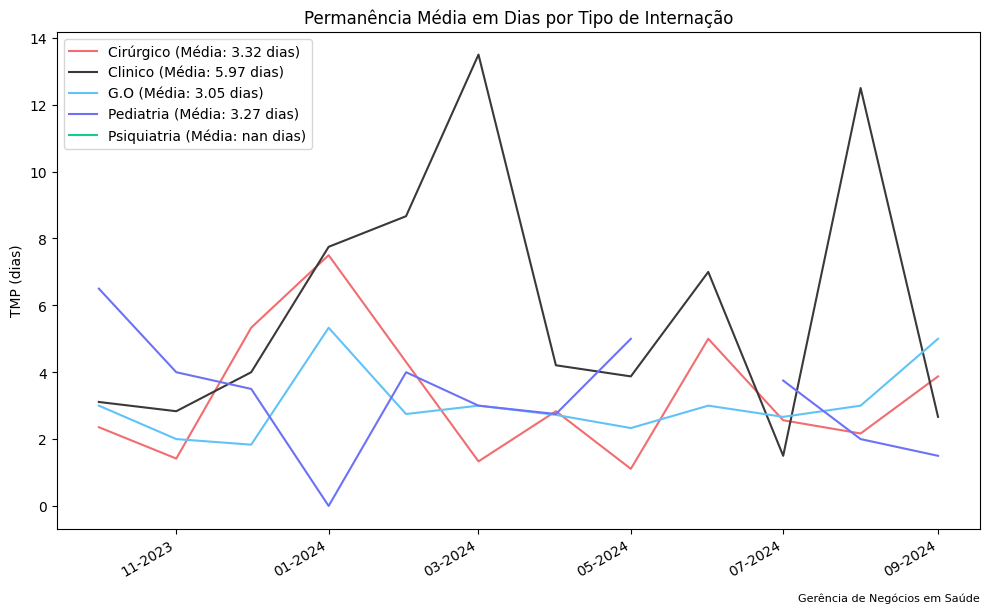

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Supondo que df5 já tenha sido carregado e 'Mês' esteja no formato datetime

# Filtrar pelas especialidades desejadas
especialidades_desejadas = ['Cirúrgico', 'Clinico', 'G.O', 'Pediatria', 'Psiquiatria']
df_especialidades = df5[df5['Epecialidade'].isin(especialidades_desejadas)]

# Agrupar por mês e especialidade e calcular a média de TMP
tmp_por_mes_especialidade = df_especialidades.groupby(['Mês', 'Epecialidade'])['TMP'].mean().unstack()

# Ordenar por mês (índice)
tmp_por_mes_especialidade = tmp_por_mes_especialidade.sort_index()

# Filtrar para o período desejado
inicio_periodo = pd.to_datetime('10-2023', format='%m-%Y')
fim_periodo = pd.to_datetime('09-2024', format='%m-%Y')
tmp_por_mes_especialidade = tmp_por_mes_especialidade[(tmp_por_mes_especialidade.index >= inicio_periodo) & (tmp_por_mes_especialidade.index <= fim_periodo)]

# Definir as cores para cada especialidade
cores = {
    'Cirúrgico': '#F16D70',  # #ED1C24 10% mais claro
    'Clinico': '#3A3838',
    'G.O': '#60C3F8',
    'Pediatria': '#6C71F6',
    'Psiquiatria': '#12CD8C'  # #231F20 20% mais claro
}

# Criar o gráfico
fig, ax = plt.subplots(figsize=(10, 6))

# Loop para plotar uma linha para cada especialidade, com a média na legenda
for especialidade in especialidades_desejadas:
    if especialidade in tmp_por_mes_especialidade.columns:
        # Calcular a média de TMP para cada especialidade
        media_tmp = tmp_por_mes_especialidade[especialidade].mean()

        # Plotar a linha para a especialidade
        ax.plot(tmp_por_mes_especialidade.index, tmp_por_mes_especialidade[especialidade],
                label=f'{especialidade} (Média: {media_tmp:.2f} dias)',
                color=cores[especialidade])

# Formatar o eixo X para exibir no formato 'mm-aaaa'
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
fig.autofmt_xdate()

# Definir rótulos e título
ax.set_xlabel('')
ax.set_ylabel('TMP (dias)')
ax.set_title('Permanência Média em Dias por Tipo de Internação')

# Adicionar legenda
ax.legend()

# Mostrar o gráfico
plt.tight_layout()

# Adicionar a notação "Gerência de Negócios em Saúde" no canto inferior direito
plt.text(1, -0.15, "Gerência de Negócios em Saúde", transform=plt.gca().transAxes,
         fontsize=8, horizontalalignment='right', verticalalignment='bottom')

plt.show()



In [ ]:
import pandas as pd

# Certifique-se de que a coluna 'Mês' esteja no formato datetime
df5['Mês'] = pd.to_datetime(df5['Mês'], format='%m-%Y')

# Definir o período de filtragem: de 10-2023 a 09-2024
inicio_periodo = pd.to_datetime('10-2023', format='%m-%Y')
fim_periodo = pd.to_datetime('09-2024', format='%m-%Y')

# Filtrar o DataFrame dentro do período desejado e pela especialidade 'Geral'
df_filtrado = df5[
    (df5['Mês'] >= inicio_periodo) &
    (df5['Mês'] <= fim_periodo) &
    (df5['Epecialidade'] == 'Geral')  # Filtrar por especialidade 'Geral'
]

# Exibir o TMP mês a mês
tmp_por_mes = df_filtrado.groupby('Hospital')['TMP'].mean()  # Calcula a média do TMP por mês

print(tmp_por_mes)

Hospital
Monte Sinai                    5.446364
Nossa Senhora da Saúde         2.504167
Santa Casa de Diamantina       4.798333
Santa Casa de Montes Claros    3.180000
São Vicente de Paulo           2.100000
Name: TMP, dtype: float64


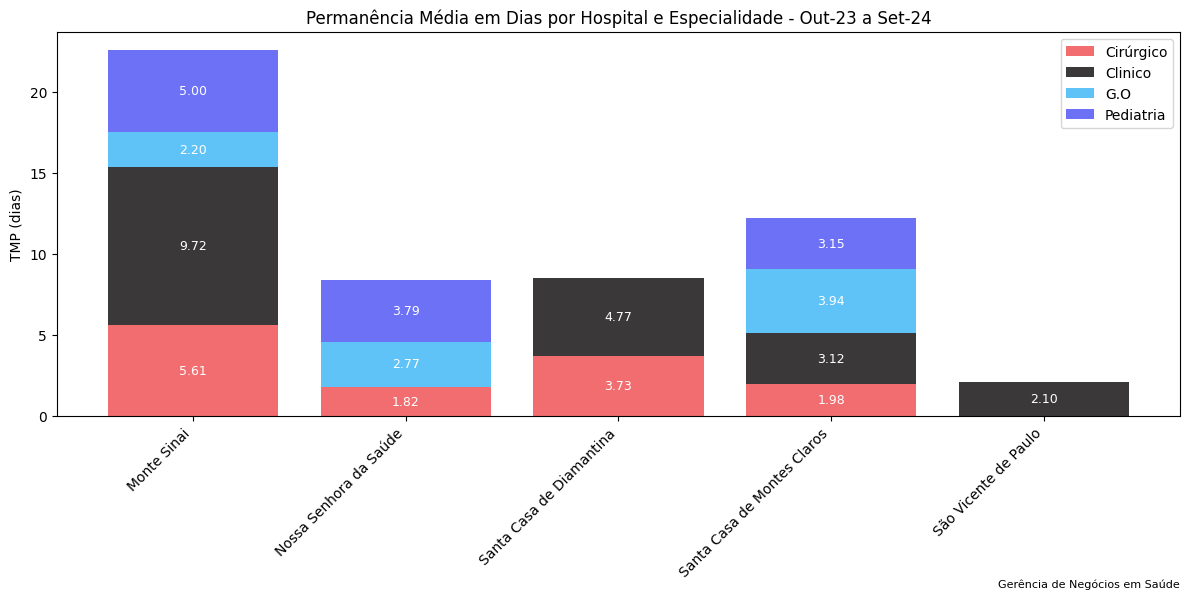

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Supondo que df5 já tenha sido carregado e 'Mês' esteja no formato datetime
df5['Mês'] = pd.to_datetime(df5['Mês'], format='%Y-%m')

# Filtrar pelas especialidades desejadas e pelo período de '10-2023' a '09-2024'
especialidades_desejadas = ['Cirúrgico', 'Clinico', 'G.O', 'Pediatria', 'Psiquiatria']
inicio_periodo = pd.to_datetime('10-2023', format='%m-%Y')
fim_periodo = pd.to_datetime('09-2024', format='%m-%Y')
df_especialidades = df5[(df5['Epecialidade'].isin(especialidades_desejadas)) & (df5['Mês'] >= inicio_periodo) & (df5['Mês'] <= fim_periodo)]

# Agrupar por Hospital e Especialidade e calcular a média de TMP
tmp_por_hospital_especialidade = df_especialidades.groupby(['Hospital', 'Epecialidade'])['TMP'].mean().unstack()

# Definir as cores para cada especialidade
cores = {
    'Cirúrgico': '#F16D70',  # #ED1C24 10% mais claro
    'Clinico': '#3A3838',
    'G.O': '#60C3F8',
    'Pediatria': '#6C71F6',
    'Psiquiatria': '#12CD8C'
}

# Criar o gráfico de barras empilhadas
fig, ax = plt.subplots(figsize=(12, 6))

# Definir a posição das barras no eixo x
hospitais = tmp_por_hospital_especialidade.index
pos = np.arange(len(hospitais))

# Iniciar o empilhamento de barras com o valor inicial em 0
bottom = np.zeros(len(hospitais))

# Loop para criar as barras empilhadas por especialidade
for especialidade in especialidades_desejadas:
    if especialidade in tmp_por_hospital_especialidade.columns:
        # Plotar as barras empilhadas para cada especialidade
        bars = ax.bar(pos, tmp_por_hospital_especialidade[especialidade], label=f'{especialidade}',
                      color=cores[especialidade], bottom=bottom)

        # Adicionar o rótulo no centro da barra com duas casas decimais
        for bar, valor in zip(bars, tmp_por_hospital_especialidade[especialidade].fillna(0)):
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2,
                        f'{valor:.2f}', ha='center', va='center', fontsize=9, color='white')

        # Atualizar o "bottom" para a próxima empilhada
        bottom += tmp_por_hospital_especialidade[especialidade].fillna(0)

# Adicionar os nomes dos hospitais no eixo x
ax.set_xticks(pos)
ax.set_xticklabels(hospitais, rotation=45, ha='right')

# Definir rótulos e título
ax.set_xlabel('')
ax.set_ylabel('TMP (dias)')
ax.set_title('Permanência Média em Dias por Hospital e Especialidade - Out-23 a Set-24')

# Adicionar a legenda com as médias
ax.legend(loc='upper right')

# Mostrar o gráfico
plt.tight_layout()

# Adicionar a notação "Gerência de Negócios em Saúde" no canto inferior direito
plt.text(1, -0.45, "Gerência de Negócios em Saúde", transform=plt.gca().transAxes,
         fontsize=8, horizontalalignment='right', verticalalignment='bottom')

plt.show()


In [ ]:
#Internações e Diárias
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

# Abra a planilha pelo nome
planilha = gc.open("go_hosp")

# Selecione uma aba pelo nome
aba = planilha.worksheet("inter_diarias")

import pandas as pd
import numpy as np

dados = aba.get_all_values()
cabecalho = dados[0]  # A primeira linha contém o cabeçalho
valores = dados[1:]   # As linhas restantes contêm os valores

dados = aba.get_all_values()
cabecalho = dados[0]  # A primeira linha contém o cabeçalho
valores = dados[1:]   # As linhas restantes contêm os valores

df6 = pd.DataFrame(valores, columns=cabecalho)  # Create df6

df6.head()

,Mês,Hospital,cod_hosp,Internações,Diárias
0,01/01/2023 00:00:00,Monte Sinai,4,1,7
1,01/01/2023 00:00:00,Nossa Senhora da Saúde,1,4,22
2,01/01/2023 00:00:00,Santa Casa de Montes Claros,5,3,26
3,01/02/2023 00:00:00,Monte Sinai,4,4,13
4,01/02/2023 00:00:00,Nossa Senhora da Saúde,1,3,6


In [ ]:
#descobrir formato colunas
df6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Mês           92 non-null     object
 1   Hospital      92 non-null     object
 2   cod_hosp      92 non-null     object
 3   Internações   92 non-null     object
 4   Diárias       92 non-null     object
dtypes: object(5)
memory usage: 3.7+ KB


In [ ]:
# Verifique os nomes reais das colunas no DataFrame
print(df6.columns)

# Supondo que o nome real da coluna seja diferente, por exemplo, 'Mes':
# Substitua 'Mes' pelo nome correto da coluna se for diferente
df6['Mês '].unique()

Index(['Mês ', 'Hospital', 'cod_hosp', 'Internações ', 'Diárias'], dtype='object')


array(['01/01/2023 00:00:00', '01/02/2023 00:00:00',
       '01/03/2023 00:00:00', '01/04/2023 00:00:00',
       '01/05/2023 00:00:00', '01/06/2023 00:00:00',
       '01/07/2023 00:00:00', '01/08/2023 00:00:00',
       '01/09/2023 00:00:00', '01/10/2023 00:00:00',
       '01/11/2023 00:00:00', '01/12/2023 00:00:00',
       '01/01/2024 00:00:00', '01/02/2024 00:00:00',
       '01/03/2024 00:00:00', '01/04/2024 00:00:00',
       '01/05/2024 00:00:00', '01/06/2024 00:00:00',
       '01/07/2024 00:00:00', '01/08/2024 00:00:00',
       '01/09/2024 00:00:00'], dtype=object)

In [ ]:
#renomear a coluna 'Mês ' para mes
df6.rename(columns={'Mês ': 'Mês'}, inplace=True)
df6.head()

,Mês,Hospital,cod_hosp,Internações,Diárias
0,01/01/2023 00:00:00,Monte Sinai,4,1,7
1,01/01/2023 00:00:00,Nossa Senhora da Saúde,1,4,22
2,01/01/2023 00:00:00,Santa Casa de Montes Claros,5,3,26
3,01/02/2023 00:00:00,Monte Sinai,4,4,13
4,01/02/2023 00:00:00,Nossa Senhora da Saúde,1,3,6


In [ ]:
# Alternatively, if you want to convert 'Mes' to datetime:
df6['Mês'] = pd.to_datetime(df6['Mês'], format='%d/%m/%Y %H:%M:%S')

df6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Mês           92 non-null     datetime64[ns]
 1   Hospital      92 non-null     object        
 2   cod_hosp      92 non-null     object        
 3   Internações   92 non-null     object        
 4   Diárias       92 non-null     object        
dtypes: datetime64[ns](1), object(4)
memory usage: 3.7+ KB


In [ ]:
#transformar as colunas Internações e Diárias em inteiro
df6['Internações '] = df6['Internações '].astype(int)
df6['Diárias'] = df6['Diárias'].astype(int)
df6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Mês           92 non-null     datetime64[ns]
 1   Hospital      92 non-null     object        
 2   cod_hosp      92 non-null     object        
 3   Internações   92 non-null     int64         
 4   Diárias       92 non-null     int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 3.7+ KB


In [ ]:
#renomear a coluna 'Internações ' para internacões
df6.rename(columns={'Internações ': 'Internações'}, inplace=True)
df6.head()

,Mês,Hospital,cod_hosp,Internações,Diárias
0,2023-01-01,Monte Sinai,4,1,7
1,2023-01-01,Nossa Senhora da Saúde,1,4,22
2,2023-01-01,Santa Casa de Montes Claros,5,3,26
3,2023-02-01,Monte Sinai,4,4,13
4,2023-02-01,Nossa Senhora da Saúde,1,3,6


In [ ]:
#criar a coluna invest_por_hosp internações * 262.00
df6['invest_por_hosp'] = df6['Internações'] * 262.0
df6.head()

,Mês,Hospital,cod_hosp,Internações,Diárias,invest_por_hosp
0,2023-01-01,Monte Sinai,4,1,7,262.0
1,2023-01-01,Nossa Senhora da Saúde,1,4,22,1048.0
2,2023-01-01,Santa Casa de Montes Claros,5,3,26,786.0
3,2023-02-01,Monte Sinai,4,4,13,1048.0
4,2023-02-01,Nossa Senhora da Saúde,1,3,6,786.0


In [ ]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Mês              92 non-null     datetime64[ns]
 1   Hospital         92 non-null     object        
 2   cod_hosp         92 non-null     object        
 3   Internações      92 non-null     int64         
 4   Diárias          92 non-null     int64         
 5   invest_por_hosp  92 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 4.4+ KB


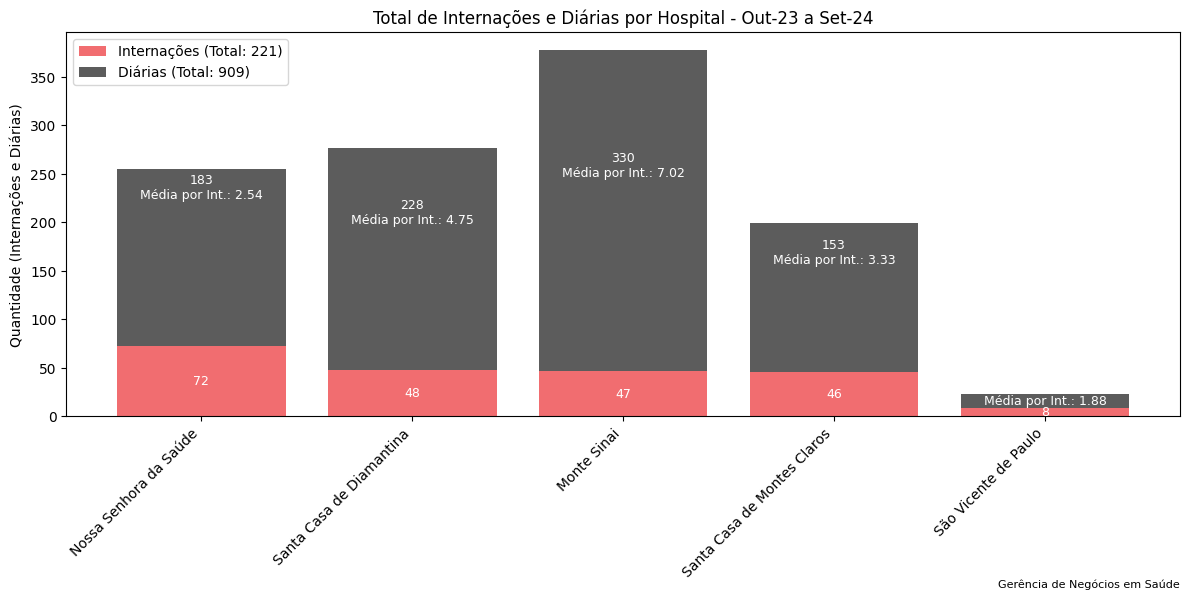

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Supondo que df6 já tenha sido carregado e a coluna 'Mês' esteja no formato datetime
df6['Mês'] = pd.to_datetime(df6['Mês'], format='%Y-%m')

# Filtrar o DataFrame para o período de '10-2023' a '09-2024'
inicio_periodo = pd.to_datetime('10-2023', format='%m-%Y')
fim_periodo = pd.to_datetime('09-2024', format='%m-%Y')
df_filtrado = df6[(df6['Mês'] >= inicio_periodo) & (df6['Mês'] <= fim_periodo)]

# Agrupar por hospital e calcular a soma das internações, diárias e investimento
df_grouped = df_filtrado.groupby('Hospital').agg({
    'Internações': 'sum',
    'Diárias': 'sum',
    'invest_por_hosp': 'sum'
}).reset_index()

# Ordenar pelo número de internações (da maior para a menor)
df_grouped = df_grouped.sort_values(by='Internações', ascending=False)

# Calcular o total de internações e diárias para o período
total_internacoes = df_grouped['Internações'].sum()
total_diarias = df_grouped['Diárias'].sum()

# Definir as posições das barras no eixo x
hospitais = df_grouped['Hospital']
pos = np.arange(len(hospitais))

# Criar o gráfico
fig, ax1 = plt.subplots(figsize=(12, 6))

# Definir cores
cor_internacoes = '#F16D70'  # #ED1C24 10% mais claro
cor_diarias = '#5C5C5C'  # #3A3838 10% mais claro

# Criar as barras empilhadas (Internações e Diárias)
bars1 = ax1.bar(pos, df_grouped['Internações'], label=f'Internações (Total: {total_internacoes:,})', color=cor_internacoes)
bars2 = ax1.bar(pos, df_grouped['Diárias'], label=f'Diárias (Total: {total_diarias:,})', bottom=df_grouped['Internações'], color=cor_diarias)

# Adicionar os rótulos de dados nas barras (Internações)
for bar, internações in zip(bars1, df_grouped['Internações']):
    height = bar.get_height()
    if height > 0:
        ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2,
                 f'{height:.0f}', ha='center', va='center', color='white', fontsize=9)

# Adicionar os rótulos de dados nas barras (Diárias) com a média de diárias por internação em nova linha
for bar, internações, diarias in zip(bars2, df_grouped['Internações'], df_grouped['Diárias']):
    height = bar.get_height()
    if height > 0:
        # Calcular a divisão da soma de Diárias pela soma de Internações
        ratio = diarias / internações if internações > 0 else 0
        # Exibir o valor de diárias e, na linha de baixo, a média de diárias por internação
        ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2 + internações,
                 f'{height:.0f}\nMédia por Int.: {ratio:.2f}', ha='center', va='center', color='white', fontsize=9)

# Adicionar os nomes dos hospitais no eixo x
ax1.set_xticks(pos)
ax1.set_xticklabels(hospitais, rotation=45, ha='right')

# Definir rótulos para o eixo y
ax1.set_ylabel('Quantidade (Internações e Diárias)')
ax1.set_title('Total de Internações e Diárias por Hospital - Out-23 a Set-24')

# Adicionar a legenda com os totais
ax1.legend(loc='upper left')

# Ajustar layout para evitar sobreposição
plt.tight_layout()

# Adiciona a notação "Gerência de Negócios em Saúde" no canto inferior direito
plt.text(1, -0.45, "Gerência de Negócios em Saúde", transform=plt.gca().transAxes,
         fontsize=8, horizontalalignment='right', verticalalignment='bottom')

# Mostrar o gráfico
plt.show()



In [150]:
#Investimento e Retorno desde o início

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

# Abra a planilha pelo nome
planilha = gc.open("go_hosp")

# Selecione uma aba pelo nome
aba = planilha.worksheet("cobrança")

import pandas as pd
import numpy as np

dados = aba.get_all_values()
cabecalho = dados[0]  # A primeira linha contém o cabeçalho
valores = dados[1:]   # As linhas restantes contêm os valores

df = pd.DataFrame(valores, columns=cabecalho)

# 1. Converter a coluna 'mes_ano' para datetime com o formato correto
df['mes_ano'] = pd.to_datetime(df['mes_ano'], format='%d/%m/%Y %H:%M:%S', errors='coerce')

# 2. Criar a coluna 'mes_ano_str' com o formato 'MM-YYYY' para agrupamento
df['mes_ano_str'] = df['mes_ano'].dt.strftime('%m-%Y')

# 3. Limpar e converter a coluna 'total_serv' para numérico
df['total_serv'] = df['total_serv'].str.strip().str.replace('.', '').str.replace(',', '.')
df['total_serv'] = pd.to_numeric(df['total_serv'], errors='coerce')
df['total_serv'] = df['total_serv'].fillna(0)  # Substitui valores NaN por 0

# 3.1 Limpar e converter a coluna 'total_int' para inteiro
df['total_int'] = df['total_int'].str.strip().str.replace('.', '').str.replace(',', '')
df['total_int'] = pd.to_numeric(df['total_int'], errors='coerce').astype('Int64')  # Convert to integer type
df['total_int'] = df['total_int'].fillna(0)  # Substitui valores NaN por 0

# 4. Converter 'mes_ano_str' para datetime para comparação precisa
df['mes_ano_str'] = pd.to_datetime(df['mes_ano_str'], format='%m-%Y')

# 5. Filtrar o DataFrame no período desejado: de '08-2022' a '09-2024'
inicio_periodo = pd.to_datetime('08-2022', format='%m-%Y')
fim_periodo = pd.to_datetime('09-2024', format='%m-%Y')
df_filtrado_total = df[(df['mes_ano_str'] >= inicio_periodo) & (df['mes_ano_str'] <= fim_periodo)]

# Certifique-se de que as colunas 'Hospital' e 'cod_hosp' existam no DataFrame
if 'Hospital' not in df.columns or 'cod_hosp' not in df.columns:
    print("As colunas 'Hospital' ou 'cod_hosp' não estão presentes no DataFrame.")
else:
    # 6. Agrupar por 'mes_ano_str', 'Hospital', e 'cod_hosp' e calcular a soma de 'total_int' e 'total_serv'
    df_agrupado_total = df_filtrado_total.groupby(['mes_ano_str'])[['total_serv']].sum().reset_index()

    # Agora todas as colunas estão no mesmo nível
    # 7. Exibir o resultado
    print(df_agrupado_total)



   mes_ano_str  total_serv
0   2022-08-01      4192.0
1   2022-09-01      3668.2
2   2022-10-01      4978.0
3   2022-11-01      5502.0
4   2022-12-01      3144.0
5   2023-01-01      3930.0
6   2023-02-01      1572.0
7   2023-03-01      6288.0
8   2023-04-01      3930.0
9   2023-05-01      3668.0
10  2023-06-01      2882.0
11  2023-07-01      4454.0
12  2023-08-01      4192.0
13  2023-09-01      1834.0
14  2023-10-01      3668.0
15  2023-11-01      5764.0
16  2023-12-01      4454.0
17  2024-01-01      3930.0
18  2024-02-01      3930.0
19  2024-03-01      3406.0
20  2024-04-01      8646.0
21  2024-05-01      5502.0
22  2024-06-01      3144.0
23  2024-07-01      2358.0
24  2024-08-01      2358.0
25  2024-09-01      5764.0


In [153]:
#criar o dataframe df_glosa
df4 = pd.DataFrame(valores, columns=cabecalho)
df_glosa = df4[['mês_ano','Total Glosado']] # Changed tuple to a list
df_glosa

,mês_ano,Total Glosado
0,01/08/2022 00:00:00,"0,00"
1,01/08/2022 00:00:00,"2066,63"
2,01/08/2022 00:00:00,"1,20"
3,01/08/2022 00:00:00,"6350,92"
4,01/08/2022 00:00:00,"175,60"
...,...,...
391,01/09/2024 00:00:00,"0,00"
392,01/09/2024 00:00:00,"0,00"
393,01/09/2024 00:00:00,"279,14"
394,01/09/2024 00:00:00,"22,49"


In [154]:
#substituir vírgula por ponto e converter para numérico
df_glosa['Total Glosado'] = df_glosa['Total Glosado'].str.replace(',', '.').astype(float)
df_glosa


<ipython-input-154-cadc8f75d0fe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_glosa['Total Glosado'] = df_glosa['Total Glosado'].str.replace(',', '.').astype(float)


,mês_ano,Total Glosado
0,01/08/2022 00:00:00,0.00
1,01/08/2022 00:00:00,2066.63
2,01/08/2022 00:00:00,1.20
3,01/08/2022 00:00:00,6350.92
4,01/08/2022 00:00:00,175.60
...,...,...
391,01/09/2024 00:00:00,0.00
392,01/09/2024 00:00:00,0.00
393,01/09/2024 00:00:00,279.14
394,01/09/2024 00:00:00,22.49


In [155]:
#renomear a coluna 'mês_ano' para mes
df_agrupado_total.rename(columns={'mes_ano_str': 'mês_ano'}, inplace=True)
df_agrupado_total.head()

,mês_ano,total_serv
0,2022-08-01,4192.0
1,2022-09-01,3668.2
2,2022-10-01,4978.0
3,2022-11-01,5502.0
4,2022-12-01,3144.0


In [156]:
#agrupar o dataframe df_glosa por 'mês_ano', somando a coluna 'Total Glosado''
df_glosa_agrupado = df_glosa.groupby('mês_ano')['Total Glosado'].sum().reset_index()
df_glosa_agrupado.head()

,mês_ano,Total Glosado
0,01/01/2023 00:00:00,99.40
1,01/01/2024 00:00:00,80.73
2,01/02/2023 00:00:00,1947.34
3,01/02/2024 00:00:00,2498.18
4,01/03/2023 00:00:00,2152.74


In [157]:
#converter a coluna 'mês_ano' do df_glosa para datetime
df_glosa_agrupado['mês_ano'] = pd.to_datetime(df_glosa_agrupado['mês_ano'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
# errors='coerce' is added to handle any invalid parsing by setting them to NaT (Not a Time)
df_glosa_agrupado.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   mês_ano        26 non-null     datetime64[ns]
 1   Total Glosado  26 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 544.0 bytes


In [158]:
# adicionar a coluna "Total Glosado" do df_glosa_agrupado no df_agrupado_total usando o merge
df_agrupado_total = pd.merge(df_agrupado_total, df_glosa_agrupado, on='mês_ano', how='left')
df_agrupado_total

,mês_ano,total_serv,Total Glosado
0,2022-08-01,4192.0,12751.57
1,2022-09-01,3668.2,6354.73
2,2022-10-01,4978.0,3548.76
3,2022-11-01,5502.0,14589.22
4,2022-12-01,3144.0,509.51
5,2023-01-01,3930.0,99.40
6,2023-02-01,1572.0,1947.34
7,2023-03-01,6288.0,2152.74
8,2023-04-01,3930.0,6443.34
9,2023-05-01,3668.0,4376.38


In [ ]:
#import pandas as pd

# 1. Calcular a média excluindo novembro de 2023
#filtered_df = df_agrupado_total[df_agrupado_total['mês_ano'] != pd.to_datetime('2023-11-01')]
#average_glosado = filtered_df['Total Glosado'].mean()

# 2. Substituir o valor de novembro de 2023 pela média
#df_agrupado_total.loc[df_agrupado_total['mês_ano'] == pd.to_datetime('2023-11-01'), 'Total Glosado'] = average_glosado

# Exibir o DataFrame atualizado
#print(df_agrupado_total)

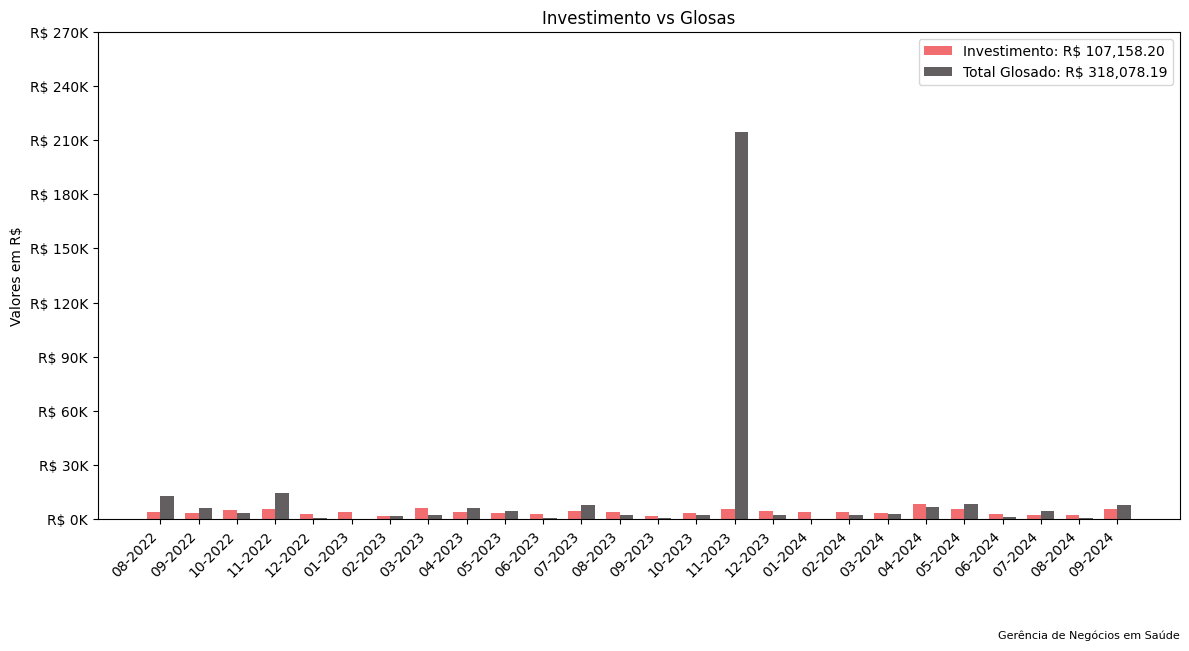

In [164]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as mtick

# Certifique-se de que 'mês_ano' esteja no formato datetime
df_agrupado_total['mês_ano'] = pd.to_datetime(df_agrupado_total['mês_ano'])

# Ordenar o DataFrame por 'mês_ano'
df_agrupado_total.sort_values(by=['mês_ano'], inplace=True)

# Formatar 'mês_ano' para '%m-%Y' para ser usado no gráfico
df_agrupado_total['mês_ano_str'] = df_agrupado_total['mês_ano'].dt.strftime('%m-%Y')

# Cores ajustadas para as barras
color_total_serv = '#F16D70'  # Cor #ED1C24 (15% mais claro)
color_total_glosado = '#635F60'  # Cor #231F20 (25% mais claro)

# Criar o gráfico de barras
fig, ax = plt.subplots(figsize=(12, 6))

# Definir a largura das barras
bar_width = 0.35

# Definir as posições das barras
x_pos = range(len(df_agrupado_total['mês_ano_str']))

# Plotar as barras para 'total_serv' com a nova cor
ax.bar(x_pos, df_agrupado_total['total_serv'], width=bar_width, color=color_total_serv, label='Investimento')

# Plotar as barras para 'Total Glosado' com a nova cor
ax.bar([p + bar_width for p in x_pos], df_agrupado_total['Total Glosado'], width=bar_width, color=color_total_glosado, label='Total Glosado')

# Definir rótulos do eixo X e rotacioná-los para melhor legibilidade
ax.set_xticks([p + bar_width / 2 for p in x_pos])
ax.set_xticklabels(df_agrupado_total['mês_ano_str'], rotation=45, ha='right')

# Definir os rótulos e título
ax.set_xlabel('')
ax.set_ylabel('Valores em R$')
ax.set_title('Investimento vs Glosas')

# Ajustar a escala do eixo y para começar em 0 e escalar de 5.000 em 5.000
ax.set_ylim(0, df_agrupado_total[['total_serv', 'Total Glosado']].max().max() + 30000)
ax.yaxis.set_ticks(range(0, int(df_agrupado_total[['total_serv', 'Total Glosado']].max().max()) + 60000, 30000))

# Formatar o eixo Y em milhares de reais (R$)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'R$ {x/1000:.0f}K'))

# Calcular os totais para cada categoria
total_serv_sum = df_agrupado_total['total_serv'].sum()
total_glosado_sum = df_agrupado_total['Total Glosado'].sum()

# Calcular o ROI (Total Glosado / Investimento)
roi = total_glosado_sum / total_serv_sum if total_serv_sum != 0 else 0

# Adicionar legenda com os totais e o ROI
ax.legend([f'Investimento: R$ {total_serv_sum:,.2f}',
           f'Total Glosado: R$ {total_glosado_sum:,.2f}',
           f'ROI: {roi:.2f}'])

# Exibir o gráfico
plt.tight_layout()

# Adiciona a notação "Gerência de Negócios em Saúde" no canto inferior direito
plt.text(1, -0.25, "Gerência de Negócios em Saúde", transform=plt.gca().transAxes,
         fontsize=8, horizontalalignment='right', verticalalignment='bottom')

plt.show()
